# **Time Series Aanalysis**

En este Notebook haremos uso de la libreria prophet de Facebook para intentar predecir el precio del bitcoin en las proximas horas, en base al sentimiento en twitter en ese instante.
Mas informacion sobre Prophet:

* https://facebook.github.io/prophet/

## Imports

In [1]:
import pandas as pd
import numpy as np
import itertools

from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.plot import plot_plotly, plot_components_plotly
import plotly.graph_objs as go

from JABA.service.scrapper import DFPicker

from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

import json
from prophet.serialize import model_to_json, model_from_json

## **Prophet**

### Pick the data

En primer lugar establecemos las fechas de inicio y fin de los datos, que por una parte se usaran para entrenar el modelo, y por otra, para establecer las fechas de las que se quiere realizar la predeccion.
Para todo esto es **necesario tener en la carpeta de data los valores de bitcoin y el sentimiento de twitter**.
Haremos uso de la funcion **get_complete_df(dateFrom, dateTo)** de **DFPicker** para recopilar los datos de las fechas de las que queremos realizar la observacion:

In [2]:
date_init = "2014-01-01"
date_limit = "2021-06-10"
date_init_predict = "2021-06-11"
date_limit_predict = "2021-06-17"

In [3]:
def get_fit_predict_data(date_init, date_limit, date_init_predict, date_limit_predict):
    
    # Data for fitting the model
    fit_df = DFPicker.get_complete_df(date_init, date_limit)
    data = { 'ds': fit_df.index.values,
             'y': fit_df.Close,
             'sentiment_v': fit_df.sentiment_v,
             'sentiment_v2': fit_df.sentiment_v2
           }
    prophet_fit_df = pd.DataFrame(data, columns=['ds', 'y', 'sentiment_v', 'sentiment_v2'])
    prophet_fit_df.reset_index(drop=True, inplace=True)
    prophet_fit_df['sentiment_v'] = prophet_fit_df['sentiment_v'].shift(periods = 36)
    prophet_fit_df['sentiment_v2'] = prophet_fit_df['sentiment_v2'].shift(periods = 36)
    for i in range(0,36):
        prophet_fit_df.drop(index=i, inplace=True)
    
    # Data for the prediction (sentiment and dates)
    future_data = DFPicker.get_complete_df(date_init_predict, date_limit_predict)
    future_data['date'] = future_data.index.values
    future_data['date'] = future_data['date'].dt.date
    grouped_data = future_data.groupby(['date']).agg({'sentiment_v' : 'mean' , 'sentiment_v2' : 'mean', 'Datetime':'count'})

    future_df = pd.concat([fit_df, grouped_data], ignore_index=False)
    future_df['ds'] = future_df.index.values
    future_df['Close'].rename('y')
    print(future_df)
    
    return prophet_fit_df, future_df, future_data
    

Recojemos los datos referentes a las fechas establecidas anteriormente.

In [4]:
prophet_fit_df, future_df, future_data = get_fit_predict_data(date_init, date_limit, date_init_predict, date_limit_predict)

Current Date 2014-01-01
Current Date 2015-01-01
Current Date 2016-01-01
Current Date 2017-01-01
Current Date 2018-01-01
Current Date 2019-01-01
Current Date 2020-01-01
Current Date 2021-01-01
Current Date 2014-01-01
Current Date 2015-01-01
Current Date 2016-01-01
Current Date 2017-01-01
Current Date 2018-01-01
Current Date 2019-01-01
Current Date 2020-01-01
Current Date 2021-01-01
Extraction Completed!
Extraction Completed!
                     sentiment_v  Datetime  sentiment_v2       Close  \
2014-01-01 00:00:00    42.848586       158     37.969439  734.104333   
2014-01-01 00:30:00    28.873142       132     25.022919  737.149667   
2014-01-01 01:00:00    31.421786       140     22.280429  738.848000   
2014-01-01 01:30:00    20.206449       105     15.187558  739.230000   
2014-01-01 02:00:00    23.173371       103     18.362825  747.851333   
...                          ...       ...           ...         ...   
2021-06-12            622.553142        48    545.567656         NaN

### Model Evaluation

Definimos una funcion para comprobar si la prediccion del modelo es correcta

In [5]:
def model_score_lower_upper(forecast, real_data, upper_value):
    score = 0

    real_data = real_data.groupby(['date']).agg({'Close' : 'mean'})

    for i in range(0,real_data.shape[0]):
        print("--------------------")
        print("Real", real_data.iloc[i])
        print("Lower", forecast.iloc[forecast.shape[0] - (real_data.shape[0]-i)].yhat_lower)
        print("Upper", forecast.iloc[forecast.shape[0] - (real_data.shape[0]-i)].yhat_upper)
        if(forecast.iloc[forecast.shape[0] - (real_data.shape[0]-i)].yhat_lower < real_data.iloc[i].Close):
            score += 1 - upper_value
        if(forecast.iloc[forecast.shape[0] - (real_data.shape[0]-i)].yhat_upper > real_data.iloc[i].Close):
            score += upper_value
        i += 1
    score = score / real_data.shape[0]
    return score
    

In [7]:
model = Prophet(changepoint_prior_scale=0.5, seasonality_prior_scale=0.5)
model.add_regressor('sentiment_v')
model.add_regressor('sentiment_v2')
model.fit(prophet_fit_df)

In [ ]:
# Generate the prediction
forecast = model.predict(future_df)

In [8]:
score_upper_lower = model_score_lower_upper(forecast, future_data, 0.1)
score_lower = model_score_lower_upper(forecast, future_data, 0)
print("La puntuacion del modelo teniendo en cuenta el Upper y el Lower es de = ", score_upper_lower)
print("La puntuacion del modelo teniendo en cuenta solo el Lower es de = ", score_lower)
print("Estas son las predicciones realizadas por el modelo:")
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(120))


--------------------
Real Close    36988.775187
Name: 2021-06-11, dtype: float64
Lower 40233.49222925897
Upper 48140.23787421033
--------------------
Real Close    35707.778931
Name: 2021-06-12, dtype: float64
Lower 40024.48310489054
Upper 47554.550651515754
--------------------
Real Close    36378.533715
Name: 2021-06-13, dtype: float64
Lower 42044.6529094816
Upper 49684.10512489563
--------------------
Real Close    39661.44266
Name: 2021-06-14, dtype: float64
Lower 41826.79888525794
Upper 49580.55070128415
--------------------
Real Close    40204.202882
Name: 2021-06-15, dtype: float64
Lower 41138.06593151644
Upper 48680.89915057893
--------------------
Real Close    39766.2465
Name: 2021-06-16, dtype: float64
Lower 40077.730838170144
Upper 47684.01526772557
--------------------
Real Close    36988.775187
Name: 2021-06-11, dtype: float64
Lower 40233.49222925897
Upper 48140.23787421033
--------------------
Real Close    35707.778931
Name: 2021-06-12, dtype: float64
Lower 40024.483104

Al parecer, en estos dias nuestro modelo no es nada preciso

### Plotting the results

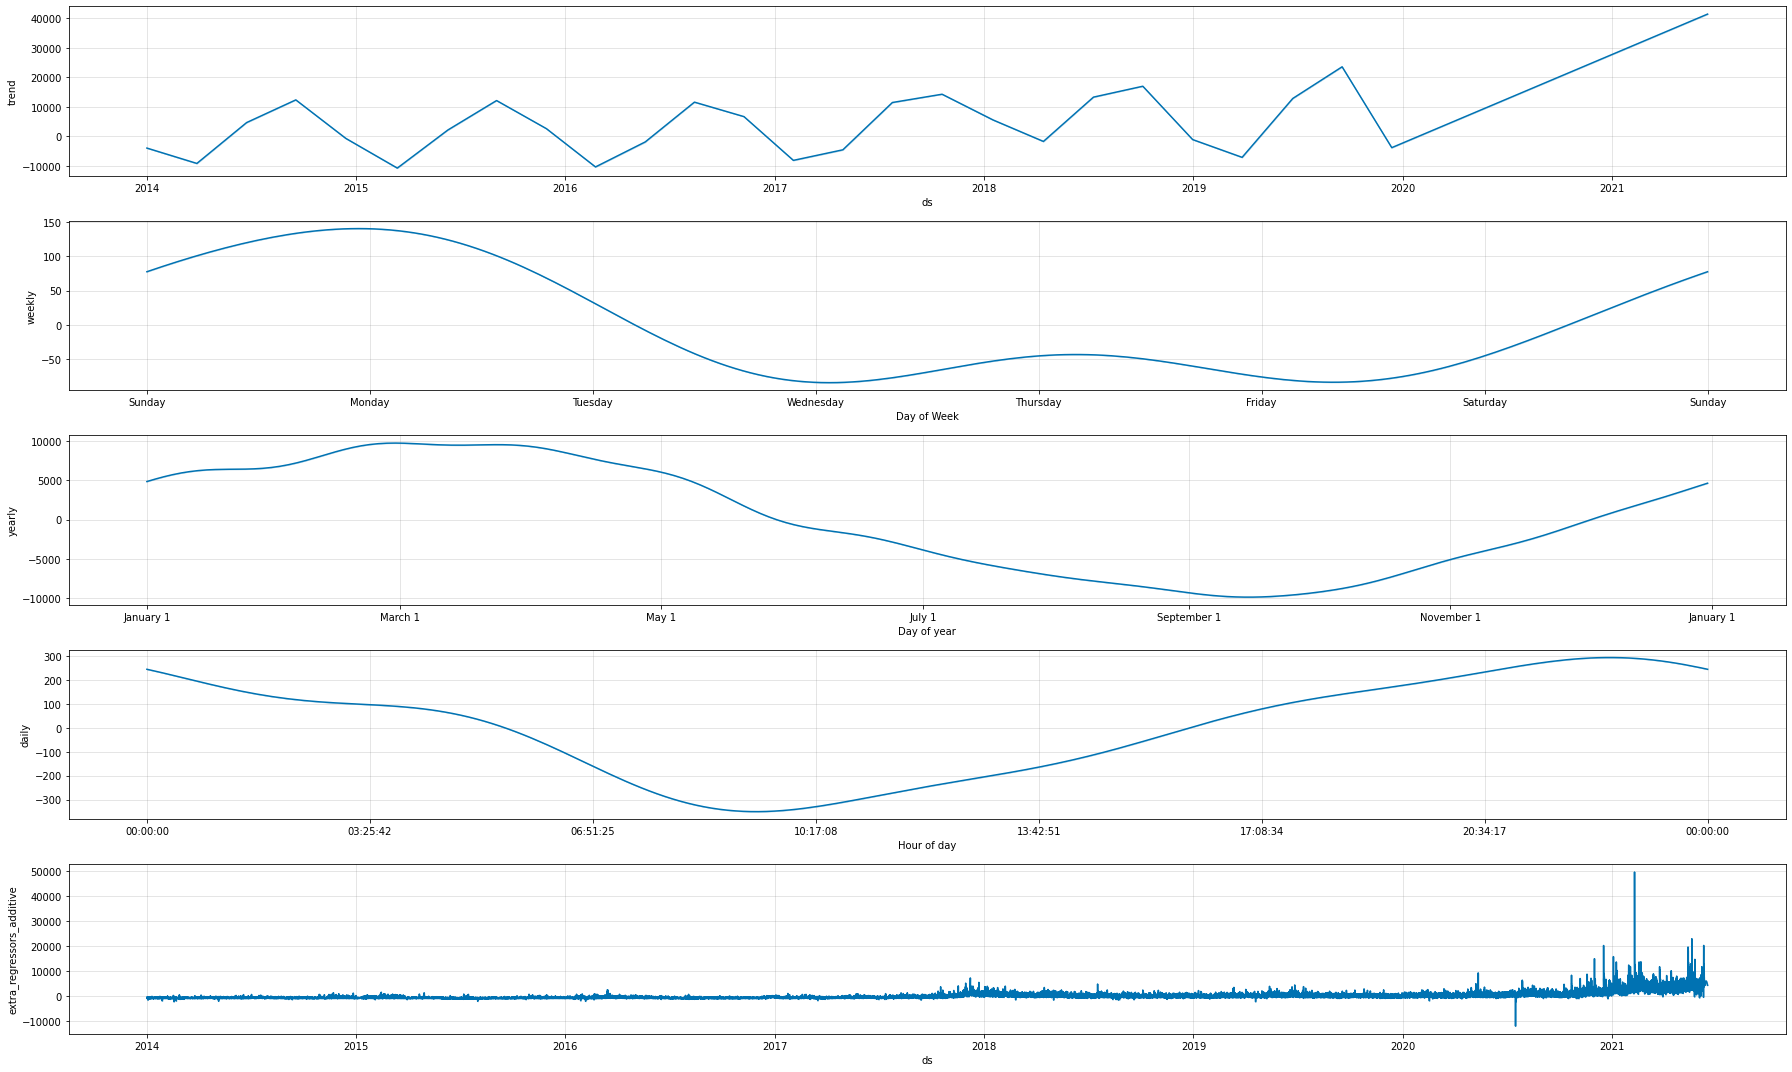

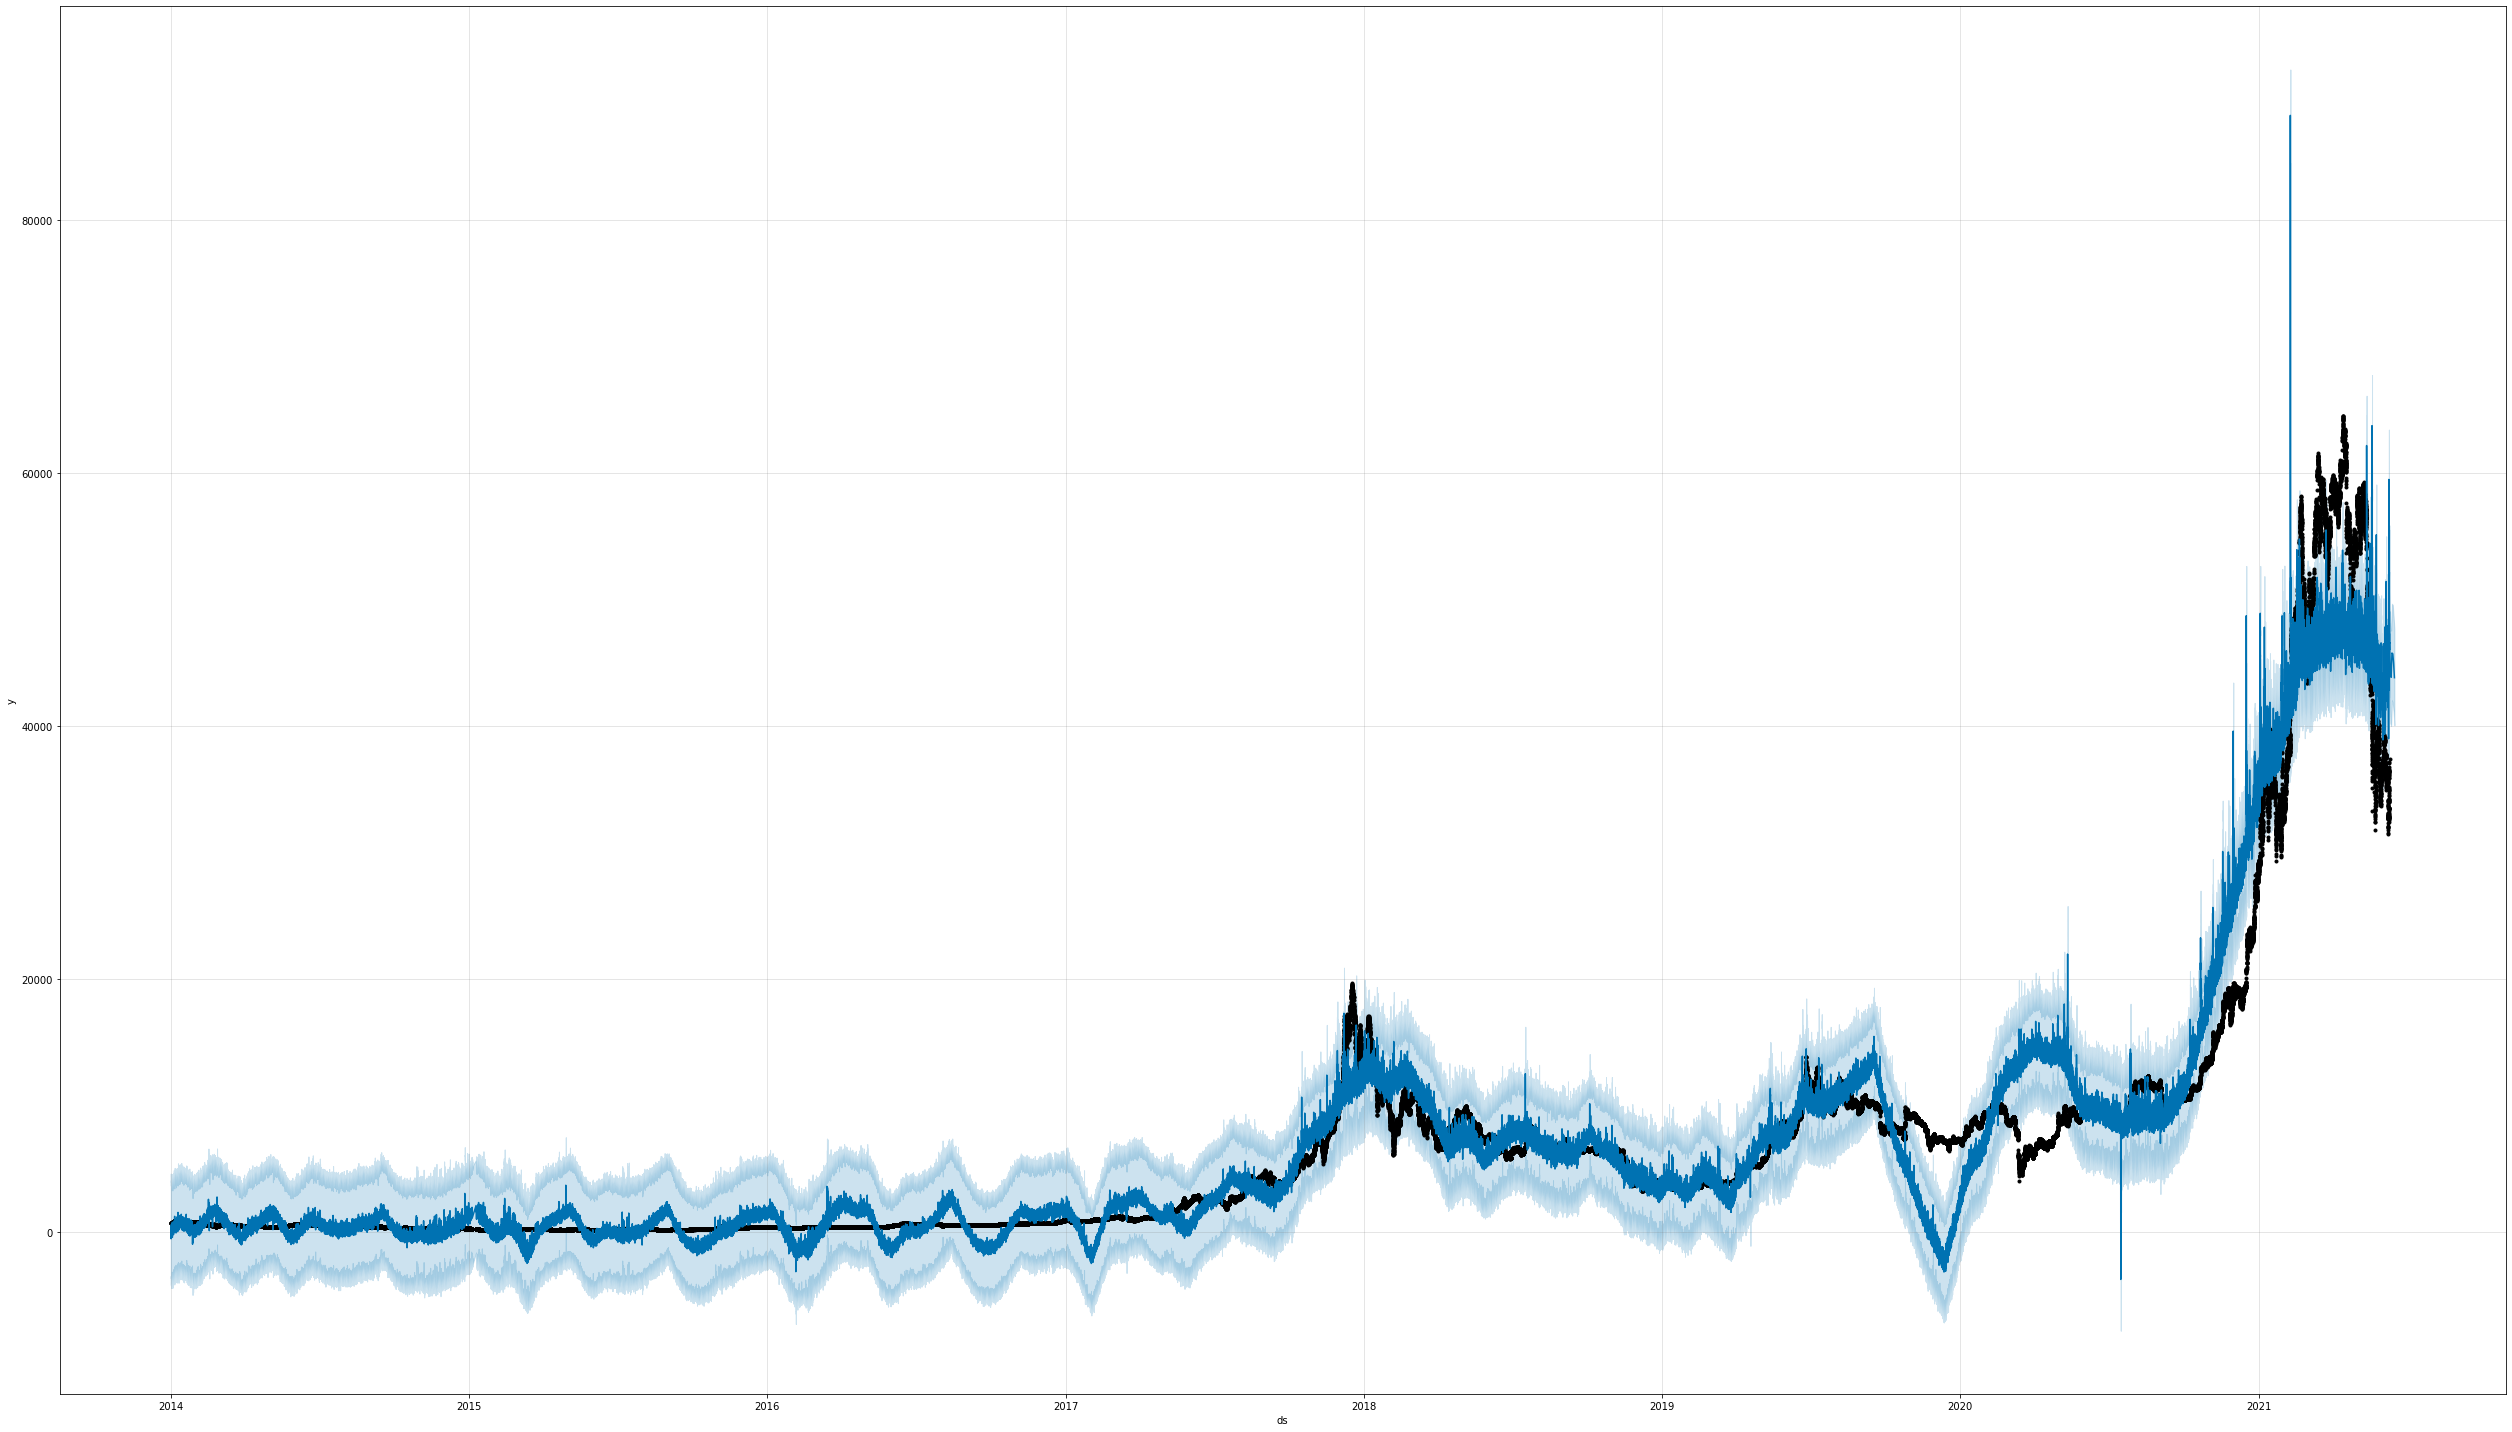

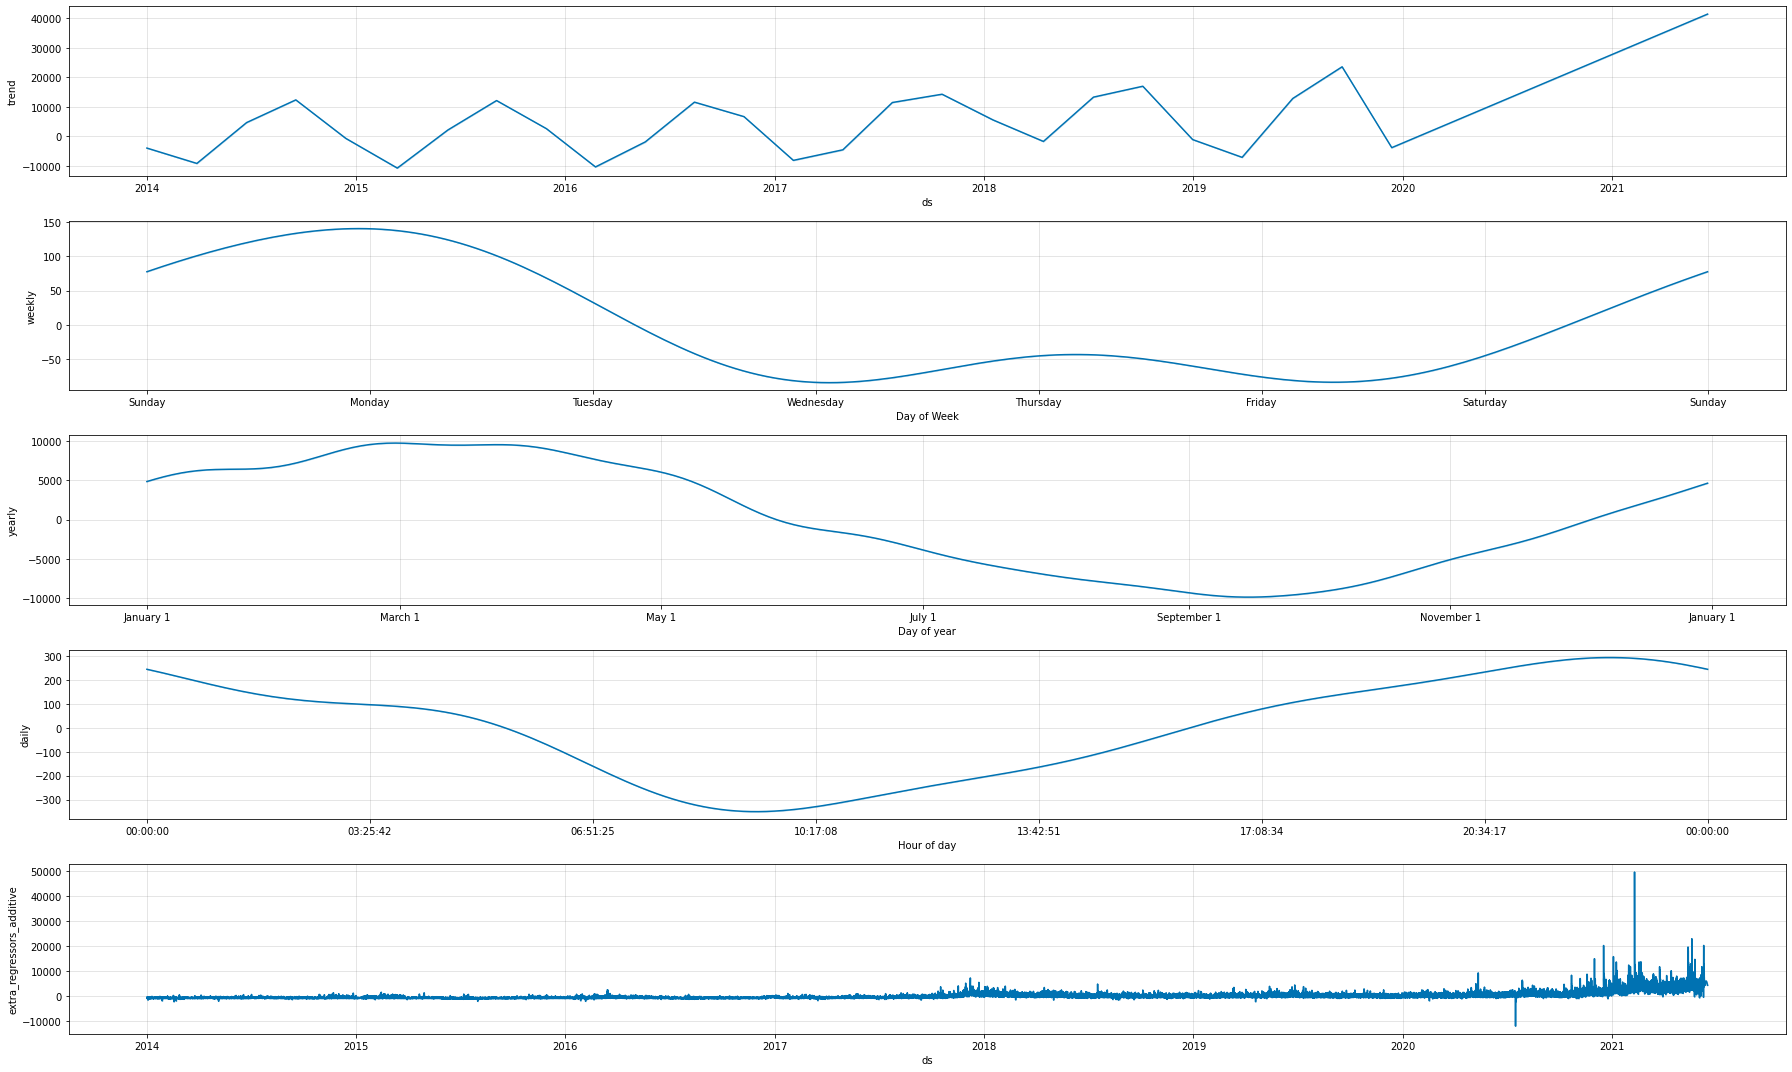

In [9]:
model.plot(forecast, figsize=(35, 20))
model.plot_components(forecast, figsize=(25, 15))

### Save the model

Podemos guardar nuestro modelo entrenado para poder hacer uso de el en un futuro.

In [10]:
with open('serialized_model.json', 'w') as fout:
    json.dump(model_to_json(model), fout) 

### Load the model

Podemos cargar el modelo guardado anteriormente de la siguiente manera

In [11]:
with open('serialized_model.json', 'r') as fin:
    m = model_from_json(json.load(fin))  

### Updating the model

Funcion que reduce el tiempo de espera para actualizar el modelo

In [ ]:
def stan_init(m):
    """Retrieve parameters from a trained model.
    
    Retrieve parameters from a trained model in the format
    used to initialize a new Stan model.
    
    Parameters
    ----------
    m: A trained model of the Prophet class.
    
    Returns
    -------
    A Dictionary containing retrieved parameters of m.
    
    """
    res = {}
    for pname in ['k', 'm', 'sigma_obs']:
        res[pname] = m.params[pname][0][0]
    for pname in ['delta', 'beta']:
        res[pname] = m.params[pname][0]
    return res

In [ ]:
df_fit_updated, df_predict_updated = get_fit_predict_data("2021-06-16", "2021-06-17", "2021-06-16", "2021-06-17")
model_updated = Prophet().fit(df_fit_updated, init=stan_init(m))

## **Cross validation**

In [12]:
df_cv = cross_validation(model, initial='2000 days', period='365 days', horizon = '5 days', parallel="processes")
df_cv.head(100)

INFO:prophet:Making 2 forecasts with cutoffs between 2020-06-04 23:30:00 and 2021-06-04 23:30:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000002D91BDAB100>


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-06-05 00:00:00,10777.605486,9707.558246,11897.142367,9787.262333,2020-06-04 23:30:00
1,2020-06-05 00:30:00,10743.700409,9644.886917,11789.503726,9794.178000,2020-06-04 23:30:00
2,2020-06-05 01:00:00,10649.612331,9570.696069,11673.257344,9812.332667,2020-06-04 23:30:00
3,2020-06-05 01:30:00,10790.031005,9801.515908,11856.952910,9822.644667,2020-06-04 23:30:00
4,2020-06-05 02:00:00,11111.555178,10006.572088,12125.584323,9815.996000,2020-06-04 23:30:00
...,...,...,...,...,...,...
95,2020-06-06 23:30:00,10854.384593,9809.155947,11789.695969,9668.889333,2020-06-04 23:30:00
96,2020-06-07 00:00:00,11031.831651,10011.579974,12086.668421,9648.871000,2020-06-04 23:30:00
97,2020-06-07 00:30:00,10951.626560,9934.753706,12001.790390,9661.319667,2020-06-04 23:30:00
98,2020-06-07 01:00:00,10838.502828,9877.781496,11862.764175,9656.634333,2020-06-04 23:30:00


In [13]:
df_p = performance_metrics(df_cv)
df_p.tail()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
212,4 days 22:00:00,4.831167e+07,6950.659367,5491.698968,0.212919,0.199463,0.190484,0.041667
213,4 days 22:30:00,4.714609e+07,6866.301005,5425.650745,0.209943,0.199463,0.188125,0.041667
214,4 days 23:00:00,4.593518e+07,6777.549453,5361.742053,0.206812,0.199463,0.185635,0.062500
215,4 days 23:30:00,4.969347e+07,7049.359770,5479.229333,0.209020,0.199463,0.187024,0.062500
216,5 days 00:00:00,5.894987e+07,7677.882178,5731.471137,0.214534,0.192182,0.190412,0.062500


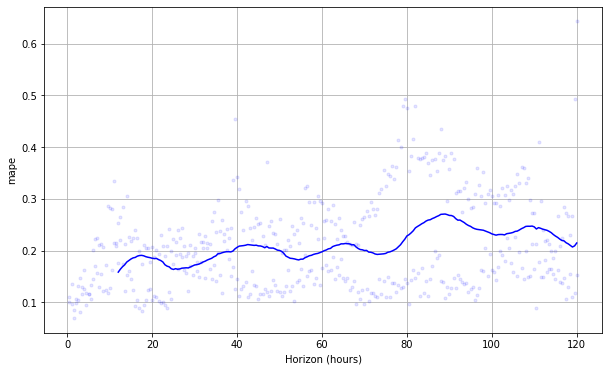

In [14]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

### Hyperparameter Tunning

Para ajustar el modelo haremos uso de cross-validation con diferentes hiperparametros, en busca del mejor resultado

In [38]:
param_grid = {  
    'changepoint_prior_scale': [0.1, 0.5, 0.8, 1.0],
    'seasonality_prior_scale': [0.5, 1.0, 2.5, 5.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
iteration = 0
for params in all_params:
    model = Prophet(**params).add_regressor('sentiment_v').add_regressor('sentiment_v2').fit(prophet_fit_df)
    df_cv = cross_validation(model, initial='2000 days', period='365 days', horizon = '5 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])
    iteration +=1 
    print(iteration)
    

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:prophet:Making 2 forecasts with cutoffs between 2020-06-04 23:30:00 and 2021-06-04 23:30:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001D544A33280>


1


INFO:prophet:Making 2 forecasts with cutoffs between 2020-06-04 23:30:00 and 2021-06-04 23:30:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001D52E30A8B0>


2


INFO:prophet:Making 2 forecasts with cutoffs between 2020-06-04 23:30:00 and 2021-06-04 23:30:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001D525D9C970>


3


INFO:prophet:Making 2 forecasts with cutoffs between 2020-06-04 23:30:00 and 2021-06-04 23:30:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001D5295EA730>


4


INFO:prophet:Making 2 forecasts with cutoffs between 2020-06-04 23:30:00 and 2021-06-04 23:30:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001D525D9C970>


5


INFO:prophet:Making 2 forecasts with cutoffs between 2020-06-04 23:30:00 and 2021-06-04 23:30:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001D526F3B1F0>


6


INFO:prophet:Making 2 forecasts with cutoffs between 2020-06-04 23:30:00 and 2021-06-04 23:30:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001D525440D00>


7


INFO:prophet:Making 2 forecasts with cutoffs between 2020-06-04 23:30:00 and 2021-06-04 23:30:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001D53FECF580>


8


INFO:prophet:Making 2 forecasts with cutoffs between 2020-06-04 23:30:00 and 2021-06-04 23:30:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001D5259A5AC0>


9


INFO:prophet:Making 2 forecasts with cutoffs between 2020-06-04 23:30:00 and 2021-06-04 23:30:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001D52599FD00>


10


INFO:prophet:Making 2 forecasts with cutoffs between 2020-06-04 23:30:00 and 2021-06-04 23:30:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001D545007DC0>


11


INFO:prophet:Making 2 forecasts with cutoffs between 2020-06-04 23:30:00 and 2021-06-04 23:30:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001D544FF0490>


12


INFO:prophet:Making 2 forecasts with cutoffs between 2020-06-04 23:30:00 and 2021-06-04 23:30:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001D544FF85E0>


13


INFO:prophet:Making 2 forecasts with cutoffs between 2020-06-04 23:30:00 and 2021-06-04 23:30:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001D525D9C790>


14


INFO:prophet:Making 2 forecasts with cutoffs between 2020-06-04 23:30:00 and 2021-06-04 23:30:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001D525F14610>


15


INFO:prophet:Making 2 forecasts with cutoffs between 2020-06-04 23:30:00 and 2021-06-04 23:30:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001D544FF85E0>


16
    changepoint_prior_scale  seasonality_prior_scale         rmse
0                       0.1                      0.5  7078.708556
1                       0.1                      1.0  7086.080618
2                       0.1                      2.5  7050.758172
3                       0.1                      5.0  7114.519272
4                       0.5                      0.5  7004.370173
5                       0.5                      1.0  7048.487927
6                       0.5                      2.5  7034.539914
7                       0.5                      5.0  7060.371883
8                       0.8                      0.5  7033.912875
9                       0.8                      1.0  7041.278373
10                      0.8                      2.5  7038.559047
11                      0.8                      5.0  7050.275570
12                      1.0                      0.5  7035.385998
13                      1.0                      1.0  7022.601101
14     

Tras un largo proceso de analisis podemos concluir que los mejores hiperparametros para el modelos son:
* changepoint_prior_scale = 0.5
* seasonality_prior_scale = 0.5